## Librerías

In [1]:
import numpy as np 
import pandas as pd
import joblib
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
from mpl_toolkits.mplot3d import Axes3D
from skimage import feature, data, color 
import os
from tqdm import tqdm 
from skimage.transform import resize 
from skimage.io import imread
from sklearn.feature_extraction.image import PatchExtractor
from itertools import chain 
from scipy import stats 
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.naive_bayes import GaussianNB 
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from utils import optimize_model_and_faces_with_optuna, mlp_param_transformer, plot_optimization_results, plot_pca_analysis #, extract_patches

#Metricas de performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
os.getcwd()

'/Users/josefina.lin/Documents/GitHub/ORT-AI/ML para AI/Obligatorio'

## Importar Caras y Fondos

In [3]:
suffix = '.pgm'

all_files = os.listdir('Faces/')
pgm_files = [filename for filename in all_files if filename.endswith(suffix)]

In [4]:
positive_patches = []
for filename in tqdm(pgm_files):
  path = 'Faces/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  positive_patches.append(image)

100%|██████████| 12833/12833 [00:03<00:00, 3523.01it/s]


In [5]:
positive_patches = np.array(positive_patches)
positive_patches.shape

(12833, 64, 64)

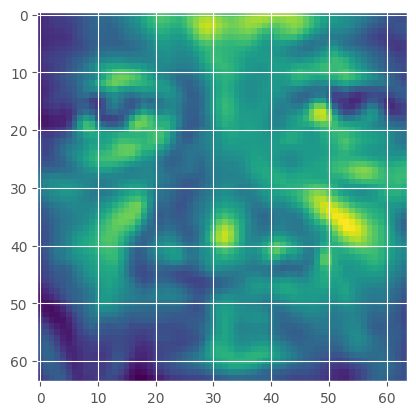

In [6]:
plt.imshow(positive_patches[1])
plt.show()

In [7]:
# Función para extraer porciones de una imagen
def extract_patches(img, N, scale=1.0, patch_size = (64, 64)):
    # Calcula el tamaño del parche extraído basado en el factor de escala dado
    extracted_patch_size = tuple((scale * np.array(patch_size)).astype(int))

    # Inicializa un objeto PatchExtractor con el tamaño de parche calculado,
    # el número máximo de parches, y una semilla de estado aleatorio
    extractor = PatchExtractor(patch_size=extracted_patch_size, max_patches=N, random_state=0)

    # Extrae parches de la imagen dada
    # img[np.newaxis] se utiliza la entrada de PatchExtractor es un conjunto de imágenes
    patches = extractor.transform(img[np.newaxis])

    # Si el factor de escala no es 1, redimensiona cada parche extraído
    # al tamaño del parche original
    if scale != 1:
        patches = np.array([resize(patch, patch_size) for patch in patches])

    # Devuelve la lista de parches extraídos (y posiblemente redimensionados)
    return patches

In [8]:
# Tomamos algunas imágenes de sklearn
imgs = ['text',
        'coins',
        'moon',
        'page',
        'clock',
        'immunohistochemistry',
        'chelsea',
        'coffee',
        'hubble_deep_field'
        ]

images = []
for name in imgs:
    img = getattr(data, name)()
    if len(img.shape) == 3 and img.shape[2] == 3:  # Chequeamos si la imagen es RGB
        img = color.rgb2gray(img)
        # img = (img * 255).astype(np.uint8)
    images.append(resize(img, (100,100)))

# Imagenes caseras adicionales
background_files = [f for f in os.listdir('Generar_Fondos') if f.endswith('.jpg')]
for filename in background_files:
    img = plt.imread('Generar_Fondos/' + filename)
    img = color.rgb2gray(img)
    images.append(resize(img, (100,100)))

In [9]:
# Extraemos las imágenes de fondo
negative_patches = np.vstack([extract_patches(im, 64, scale) for im in tqdm(images, desc='Procesando imágenes') for scale in [0.1,0.25,0.5,0.75,1]])
negative_patches.shape

Procesando imágenes: 100%|██████████| 60/60 [00:01<00:00, 34.77it/s]


(19200, 64, 64)

In [10]:
P = len(positive_patches)
N = len(negative_patches)

In [11]:
positive_patches = np.array(positive_patches)
print('positive_patches:',positive_patches.shape)

negative_patches = np.array(negative_patches)
print('negative_patches:',negative_patches.shape)

positive_patches: (12833, 64, 64)
negative_patches: (19200, 64, 64)


In [12]:
positive_patches

array([[[ 93, 109, 118, ..., 141, 141, 128],
        [ 88, 105, 116, ..., 136, 139, 134],
        [ 91, 105, 116, ..., 131, 135, 135],
        ...,
        [ 38,  34,  27, ..., 153, 188, 220],
        [ 35,  32,  26, ..., 199, 229, 234],
        [ 33,  32,  29, ..., 228, 240, 225]],

       [[ 68,  72,  76, ...,  88,  84,  82],
        [ 68,  73,  76, ...,  88,  87,  87],
        [ 69,  73,  75, ...,  87,  89,  90],
        ...,
        [ 84,  94,  96, ...,  99,  93,  88],
        [ 79,  90,  94, ...,  97,  92,  88],
        [ 74,  85,  90, ...,  94,  89,  88]],

       [[105, 109, 112, ..., 175, 166, 163],
        [105, 110, 113, ..., 173, 164, 159],
        [105, 109, 108, ..., 174, 166, 160],
        ...,
        [145, 140, 105, ..., 208, 146,  49],
        [132, 139, 115, ..., 208, 144,  40],
        [126, 133, 116, ..., 208, 148,  37]],

       ...,

       [[138, 142, 145, ..., 163, 148, 131],
        [141, 146, 148, ..., 162, 146, 129],
        [143, 149, 150, ..., 160, 145, 130

In [13]:
negative_patches

array([[[0.4317259 , 0.44254155, 0.45335721, ..., 0.50870194,
         0.50773631, 0.50677068],
        [0.4288775 , 0.43963401, 0.45039052, ..., 0.50785415,
         0.50678211, 0.50571007],
        [0.42602909, 0.43672646, 0.44742383, ..., 0.50700636,
         0.50582791, 0.50464945],
        ...,
        [0.56926828, 0.57183059, 0.57439289, ..., 0.39606439,
         0.40072611, 0.40538783],
        [0.56836983, 0.57090794, 0.57344605, ..., 0.40158727,
         0.40453217, 0.40747706],
        [0.56747138, 0.56998529, 0.5724992 , ..., 0.40711015,
         0.40833822, 0.40956629]],

       [[0.50395018, 0.50259958, 0.50124898, ..., 0.36731131,
         0.37341773, 0.37952414],
        [0.5063919 , 0.50499438, 0.50359686, ..., 0.35747061,
         0.36429876, 0.3711269 ],
        [0.50883362, 0.50738918, 0.50594473, ..., 0.34762991,
         0.35517979, 0.36272966],
        ...,
        [0.44839405, 0.43843179, 0.42846954, ..., 0.46971596,
         0.47061423, 0.47151251],
        [0.4

In [14]:
negative_patches = (negative_patches*255).astype(np.uint8)

negative_patches

array([[[110, 112, 115, ..., 129, 129, 129],
        [109, 112, 114, ..., 129, 129, 128],
        [108, 111, 114, ..., 129, 128, 128],
        ...,
        [145, 145, 146, ..., 100, 102, 103],
        [144, 145, 146, ..., 102, 103, 103],
        [144, 145, 145, ..., 103, 104, 104]],

       [[128, 128, 127, ...,  93,  95,  96],
        [129, 128, 128, ...,  91,  92,  94],
        [129, 129, 129, ...,  88,  90,  92],
        ...,
        [114, 111, 109, ..., 119, 120, 120],
        [115, 112, 110, ..., 119, 119, 120],
        [116, 113, 111, ..., 119, 119, 119]],

       [[141, 141, 141, ..., 147, 147, 146],
        [141, 141, 141, ..., 147, 147, 146],
        [141, 141, 141, ..., 147, 147, 147],
        ...,
        [142, 142, 142, ..., 146, 146, 145],
        [142, 142, 141, ..., 146, 146, 146],
        [141, 141, 141, ..., 146, 146, 146]],

       ...,

       [[104, 107, 110, ..., 201, 194, 204],
        [106, 110, 113, ..., 190, 196, 201],
        [121, 129, 133, ..., 214, 206, 211

In [15]:
X = np.array([feature.hog(im) for im in tqdm(chain(positive_patches, negative_patches), desc='Construyendo X')])
y = np.zeros(len(X))
y[:P] = 1

Construyendo X: 32033it [00:13, 2301.60it/s]


In [16]:
X

array([[0.11646401, 0.03128126, 0.00558129, ..., 0.        , 0.01059255,
        0.03064134],
       [0.05215952, 0.01875931, 0.08044653, ..., 0.03149585, 0.09934855,
        0.13186444],
       [0.09338918, 0.01034122, 0.00889002, ..., 0.00365123, 0.01220339,
        0.15453749],
       ...,
       [0.01412594, 0.        , 0.01198015, ..., 0.11166409, 0.24912053,
        0.04256966],
       [0.19824994, 0.07418107, 0.02699928, ..., 0.05689269, 0.13233471,
        0.1334669 ],
       [0.06520012, 0.00221218, 0.00569407, ..., 0.02781517, 0.06629227,
        0.        ]])

In [17]:
y

array([1., 1., 1., ..., 0., 0., 0.])

# Modelos

## Neural Network

In [18]:
from sklearn.neural_network import MLPClassifier  

In [19]:
params = {
    # Arquitectura de la red
    'n_layers': {'type': 'int', 'low': 1, 'high': 3}, # Número de capas ocultas
    'n_units_l0': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la primera capa
    'n_units_l1': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la segunda capa (si n_layers >= 2)
    'n_units_l2': {'type': 'int', 'low': 32, 'high': 256, 'log': True}, # Neuronas para la tercera capa (si n_layers == 3)

    # Función de activación
    'activation': {'type': 'categorical', 'choices': ['relu', 'tanh']},

    # Algoritmo de optimización
    'solver': {'type': 'categorical', 'choices': ['adam', 'sgd']},

    # Regularización L2
    'alpha': {'type': 'float', 'low': 1e-5, 'high': 1e-2, 'log': True}, # Término de penalización L2

    # Tasa de aprendizaje inicial (especialmente relevante para 'sgd', 'adam' la gestiona mejor)
    'learning_rate_init': {'type': 'float', 'low': 1e-4, 'high': 1e-2, 'log': True},

    # Tamaño del batch (si el solver lo soporta, como 'adam' o 'sgd')
    'batch_size': {'type': 'categorical', 'choices': [32, 64, 128]}, # Comunes para datasets medianos

    # Número máximo de iteraciones (épocas)
    'max_iter': {'type': 'int', 'low': 200, 'high': 1000},

    # Parámetros específicos para el solver 'sgd'
    'momentum': {'type': 'float', 'low': 0.8, 'high': 0.99}, # Aplicable solo si solver='sgd'
    'nesterovs_momentum': {'type': 'categorical', 'choices': [True, False]} # Aplicable solo si solver='sgd'
}

In [20]:
from sklearn.neural_network import MLPClassifier

# Definir parámetros personalizados para MLP
mlp_params = {
    'n_layers': {'type': 'int', 'low': 1, 'high': 3},
    'n_units_l0': {'type': 'int', 'low': 32, 'high': 256},
    'n_units_l1': {'type': 'int', 'low': 32, 'high': 256}, 
    'n_units_l2': {'type': 'int', 'low': 32, 'high': 256},
    'activation': {'type': 'categorical', 'choices': ['relu', 'tanh']},
    'solver': {'type': 'categorical', 'choices': ['adam', 'sgd']},
    'alpha': {'type': 'float', 'low': 1e-5, 'high': 1e-2, 'log': True},
    'learning_rate_init': {'type': 'float', 'low': 1e-4, 'high': 1e-2, 'log': True},
    'batch_size': {'type': 'categorical', 'choices': [32, 64, 128]},
    'max_iter': {'type': 'int', 'low': 200, 'high': 1000}
}

# Ejecutar optimización CON el transformador de parámetros
results = optimize_model_and_faces_with_optuna(
    positive_patches, 
    negative_patches,
    model_class=MLPClassifier,
    param_distributions=mlp_params,
    param_transformer=mlp_param_transformer, 
    n_trials=20,
    optimize_faces=True,
    optimize_pca=False,
    fixed_pca_params={'n_components': 500, 'whiten': True}
)

[I 2025-06-29 16:01:32,398] A new study created in memory with name: no-name-12ca0ac8-5a38-46f5-b826-cf9515879b87


Starting model-agnostic optimization with Optuna...
Model: MLPClassifier
Using 5-fold cross-validation for optimization
Parameters to optimize: ['activation']
Also optimizing: Number of faces (P)
Trials: 1


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 16:02:06,136] Trial 0 finished with value: 0.9916688239247465 and parameters: {'activation': 'tanh', 'n_positive_samples': 8000}. Best is trial 0 with value: 0.9916688239247465.

Optimization completed!
Best CV F1-score: 0.9917
Best parameters:
  activation: tanh
  n_positive_samples: 8000

Training final model and evaluating on held-out test set...

=== FINAL RESULTS ===
Cross-validation F1-score (optimization): 0.9917
Test set F1-score (final evaluation): 0.9909
Best number of positive samples (P): 8000

Detailed test set results:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3840
         1.0       1.00      0.99      0.99      1600

    accuracy                           0.99      5440
   macro avg       0.99      0.99      0.99      5440
weighted avg       0.99      0.99      0.99      5440



In [21]:
results_nn = results

In [23]:
joblib.dump(results['trained_model'], 'models/nn_optimized.joblib') 

In [24]:
from utils import plot_pca_analysis_plotly, confusion_matrix

In [25]:
plot_pca_analysis_plotly(results_nn, results_nn['X_train_pca'], results_nn['y_train'])

In [26]:
confusion_matrix(results_nn)

Matriz de Confusión:
 [[3833    7]
 [  22 1578]]

Verdaderos Positivos (TP): 1578
Falsos Positivos (FP): 7
Falsos Negativos (FN): 22
Verdaderos Negativos (TN): 3833

TPR (Sensibilidad/Recall) calculado manualmente: 0.9862
FPR calculado manualmente: 0.0018


(array([[3833,    7],
        [  22, 1578]]),
 0.98625,
 0.0018229166666666667)

In [ ]:
plot_optimization_results(results_nn['study'])

## Gradient Boosting

In [40]:
from sklearn.ensemble import GradientBoostingClassifier

In [41]:
params={
    'n_estimators': {'type': 'int', 'low': 50, 'high': 300, 'step': 10},
    'max_depth': {'type': 'int', 'low': 3, 'high': 10},
    'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.5, 'log': True},
    'subsample': {'type': 'float', 'low': 0.5, 'high': 1.0},
    'max_features': {'type': 'categorical', 'choices': ['sqrt', 'log2', None]}
}

In [42]:
results = optimize_model_and_faces_with_optuna(
    positive_patches, 
    negative_patches,
    model_class=GradientBoostingClassifier,
    param_distributions=params,
    n_trials=20,
    cv_folds=5,
    test_size=0.2,  
    random_state=42,
    n_jobs=-1,
    show_progress=True,
    optimize_faces=True,
    optimize_pca=False,
    fixed_pca_params={'n_components': 500, 'whiten': True}
)

[I 2025-06-29 00:43:42,044] A new study created in memory with name: no-name-a742280c-5d6a-4b85-856f-e38509c9a7cb


Starting model-agnostic optimization with Optuna...
Model: GradientBoostingClassifier
Using 5-fold cross-validation for optimization
Parameters to optimize: ['n_estimators', 'max_depth', 'learning_rate', 'subsample', 'max_features']
Also optimizing: Number of faces (P)
Trials: 20


  0%|          | 0/20 [00:00<?, ?it/s]

/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 00:44:29,072] Trial 0 finished with value: 0.9697100700265837 and parameters: {'n_estimators': 230, 'max_depth': 10, 'learning_rate': 0.01891983572490822, 'subsample': 0.5255468339504935, 'max_features': 'log2', 'n_positive_samples': 11500}. Best is trial 0 with value: 0.9697100700265837.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 00:45:29,844] Trial 1 finished with value: 0.980890404424309 and parameters: {'n_estimators': 130, 'max_depth': 7, 'learning_rate': 0.03296849780787161, 'subsample': 0.9634248406133183, 'max_features': 'sqrt', 'n_positive_samples': 11500}. Best is trial 1 with value: 0.980890404424309.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:11:40,202] Trial 2 finished with value: 0.9858493786828909 and parameters: {'n_estimators': 270, 'max_depth': 9, 'learning_rate': 0.2702360546722486, 'subsample': 0.9301299437576225, 'max_features': None, 'n_positive_samples': 5000}. Best is trial 2 with value: 0.9858493786828909.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:12:38,729] Trial 3 finished with value: 0.9350292422204424 and parameters: {'n_estimators': 270, 'max_depth': 8, 'learning_rate': 0.015024305380360491, 'subsample': 0.7080392503523234, 'max_features': 'sqrt', 'n_positive_samples': 2000}. Best is trial 2 with value: 0.9858493786828909.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:13:15,765] Trial 4 finished with value: 0.977130294776136 and parameters: {'n_estimators': 70, 'max_depth': 9, 'learning_rate': 0.06452104021312727, 'subsample': 0.6048632283942039, 'max_features': 'sqrt', 'n_positive_samples': 8500}. Best is trial 2 with value: 0.9858493786828909.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:13:47,625] Trial 5 finished with value: 0.9174698262382048 and parameters: {'n_estimators': 230, 'max_depth': 8, 'learning_rate': 0.028403125884269922, 'subsample': 0.5423246205838747, 'max_features': 'log2', 'n_positive_samples': 4000}. Best is trial 2 with value: 0.9858493786828909.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:14:11,723] Trial 6 finished with value: 0.9550146659109986 and parameters: {'n_estimators': 130, 'max_depth': 6, 'learning_rate': 0.324089381702842, 'subsample': 0.5441007869647113, 'max_features': 'log2', 'n_positive_samples': 1500}. Best is trial 2 with value: 0.9858493786828909.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:24:47,899] Trial 7 finished with value: 0.9874638157247112 and parameters: {'n_estimators': 220, 'max_depth': 5, 'learning_rate': 0.4452645800166258, 'subsample': 0.6031525611953374, 'max_features': None, 'n_positive_samples': 12500}. Best is trial 7 with value: 0.9874638157247112.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:34:14,226] Trial 8 finished with value: 0.9798476197669379 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.031071746566242488, 'subsample': 0.9401070377619682, 'max_features': None, 'n_positive_samples': 3500}. Best is trial 7 with value: 0.9874638157247112.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:34:51,067] Trial 9 finished with value: 0.9855745153033325 and parameters: {'n_estimators': 170, 'max_depth': 4, 'learning_rate': 0.11943886624168576, 'subsample': 0.8522163884398075, 'max_features': 'log2', 'n_positive_samples': 11500}. Best is trial 7 with value: 0.9874638157247112.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:43:53,951] Trial 10 finished with value: 0.9878853349802416 and parameters: {'n_estimators': 190, 'max_depth': 5, 'learning_rate': 0.1614670023565511, 'subsample': 0.6912333516193385, 'max_features': None, 'n_positive_samples': 8000}. Best is trial 10 with value: 0.9878853349802416.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 01:53:39,735] Trial 11 finished with value: 0.9869522417864257 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.16864055974420572, 'subsample': 0.6939349902805678, 'max_features': None, 'n_positive_samples': 8000}. Best is trial 10 with value: 0.9878853349802416.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 02:01:42,948] Trial 12 finished with value: 0.9889641125004431 and parameters: {'n_estimators': 170, 'max_depth': 5, 'learning_rate': 0.37661901481524807, 'subsample': 0.6365876331140304, 'max_features': None, 'n_positive_samples': 9500}. Best is trial 12 with value: 0.9889641125004431.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 02:07:06,883] Trial 13 finished with value: 0.9870122665091892 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.15126596700514355, 'subsample': 0.7902749630850554, 'max_features': None, 'n_positive_samples': 9000}. Best is trial 12 with value: 0.9889641125004431.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 02:11:00,378] Trial 14 finished with value: 0.9858521370713257 and parameters: {'n_estimators': 90, 'max_depth': 5, 'learning_rate': 0.2164338202525574, 'subsample': 0.642930229285484, 'max_features': None, 'n_positive_samples': 6500}. Best is trial 12 with value: 0.9889641125004431.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 02:23:51,419] Trial 15 finished with value: 0.9891750630210462 and parameters: {'n_estimators': 190, 'max_depth': 6, 'learning_rate': 0.06518289377976857, 'subsample': 0.7902487632773904, 'max_features': None, 'n_positive_samples': 10000}. Best is trial 15 with value: 0.9891750630210462.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 02:31:47,259] Trial 16 finished with value: 0.9887969099801003 and parameters: {'n_estimators': 110, 'max_depth': 6, 'learning_rate': 0.07300013345705064, 'subsample': 0.8155966042832832, 'max_features': None, 'n_positive_samples': 10000}. Best is trial 15 with value: 0.9891750630210462.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 02:35:45,650] Trial 17 finished with value: 0.9877168761996409 and parameters: {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.07396307655868925, 'subsample': 0.750814863658519, 'max_features': None, 'n_positive_samples': 10000}. Best is trial 15 with value: 0.9891750630210462.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 02:42:42,031] Trial 18 finished with value: 0.9855781107052823 and parameters: {'n_estimators': 160, 'max_depth': 4, 'learning_rate': 0.04655902820692209, 'subsample': 0.8695123990077571, 'max_features': None, 'n_positive_samples': 6000}. Best is trial 15 with value: 0.9891750630210462.


/Users/josefina.lin/anaconda3/lib/python3.11/site-packages/optuna/distributions.py:702: UserWarning: The distribution is specified by [1000, 12833] and step=500, but the range is not divisible by `step`. It will be replaced by [1000, 12500].
  warnings.warn(


[I 2025-06-29 02:43:42,586] Trial 19 finished with value: 0.9904283297905634 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1049699708865777, 'subsample': 0.7531597235223961, 'max_features': 'sqrt', 'n_positive_samples': 10000}. Best is trial 19 with value: 0.9904283297905634.

Optimization completed!
Best CV F1-score: 0.9904
Best parameters:
  n_estimators: 200
  max_depth: 6
  learning_rate: 0.1049699708865777
  subsample: 0.7531597235223961
  max_features: sqrt
  n_positive_samples: 10000

Training final model and evaluating on held-out test set...

=== FINAL RESULTS ===
Cross-validation F1-score (optimization): 0.9904
Test set F1-score (final evaluation): 0.9937
Best number of positive samples (P): 10000

Detailed test set results:
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      3840
         1.0       1.00      0.99      0.99      2000

    accuracy                           1.00      5840
   macro a

In [44]:
results_gb = results

In [43]:
joblib.dump(results_gb['trained_model'], 'models/gradient_boosting_optimized.joblib')

['models/gradient_boosting_optimized.joblib']

In [ ]:
plot_optimization_results(results_gb['study'])

In [ ]:
plot_pca_analysis_plotly(results_gb, results_gb['X_train_pca'], results_gb['y_train'])

In [ ]:
confusion_matrix(results_gb)